In [7]:
%load_ext autoreload
%autoreload 2
from expressiveness_benchmark.types import Plan, Task, Language, SourceRange, Program
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from interval import interval
from itertools import combinations
sns.set(style='whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
LANG_ORDER = ['python-imperative', 'python-functional', 'python-pandas', 'r', 'sql', 'datalog', 'q']

In [20]:
import subprocess as sp
for p in Program._load_all():
    try:
        p.ntokens()
    except sp.CalledProcessError as e:
        print(p)
        print(e.stderr.decode('utf-8'))
        raise

In [34]:
programs = Program.load_all()
tasks = Task.load_all()

programs = programs[programs.plan != {}] # filter where plan hasn't been labeled
programs = programs[programs.task.isin(tasks.id.tolist())] # filter programs associated to a missing task
programs['category'] = programs.task.map(lambda t: tasks[tasks.id == t].category.iloc[0])

# Global analysis

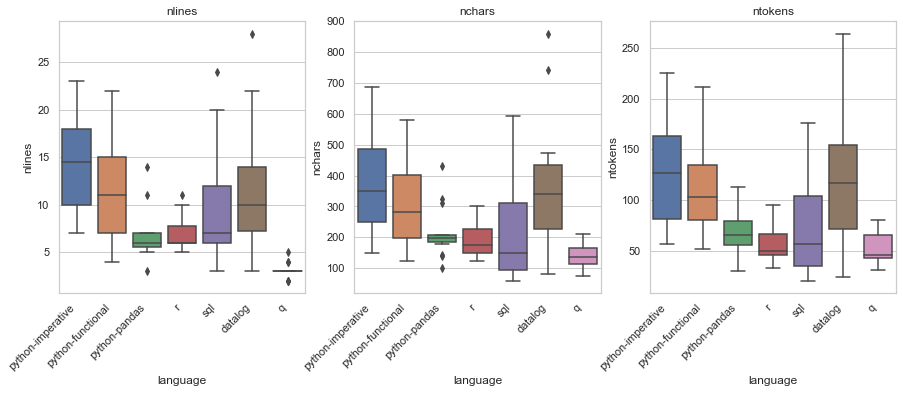

In [39]:
programs['nlines'] = programs.source.map(lambda s: len(s.split('\n')))
programs['nchars'] = programs.source.map(len)

_, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, metric in zip(axes, ['nlines', 'nchars', 'ntokens']):
    ax.set_title(metric)
    sns.boxplot(data=programs, x='language', y=metric, order=LANG_ORDER, ax=ax)
    _ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')

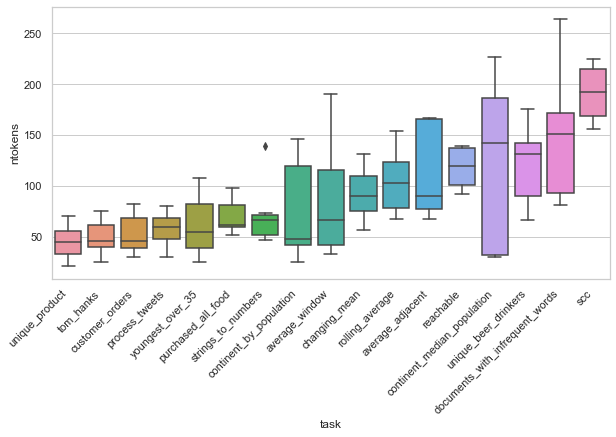

In [41]:
_, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=programs, x='task', y='ntokens', 
            order=programs.groupby('task').ntokens.mean().sort_values().index, 
            ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')

# Grouped analysis

In [43]:
from scipy.stats import zscore, rankdata

def bestworst(inner_group, outer_group, measure='ntokens', score=zscore):
    df = programs.groupby('task', as_index=False).apply(
        lambda rows: rows.assign(
            metric=score(rows[measure]))).reset_index()

    def f(df):
        df = df.groupby(inner_group).metric.mean()
        return pd.DataFrame([{'best': df.index[df.argmin()], 'worst': df.index[df.argmax()]}])

    return df.groupby(outer_group).apply(f).reset_index(level=-1, drop=True)

In [44]:
for group in ['category', 'task']:
    for score in [zscore]: # rankdata
        print(f'GROUP: {group}, SCORE: {score.__name__}')
        print(bestworst(group, 'language', score=score))
        print()

GROUP: category, SCORE: zscore
                                best              worst
language                                               
datalog                        Joins            Strings
python-functional            Strings              Joins
python-imperative            Strings        Time Series
python-pandas            Aggregation              Joins
q                  First-order logic              Joins
r                        Aggregation              Basic
sql                            Basic  First-order logic

GROUP: task, SCORE: zscore
                                          best                 worst
language                                                            
datalog                              tom_hanks    strings_to_numbers
python-functional           strings_to_numbers       customer_orders
python-imperative           strings_to_numbers        average_window
python-pandas      continent_median_population        process_tweets
q                      

In [45]:
for group in ['category', 'task']:
    for score in [zscore]: # rankdata
        print(f'GROUP: {group}, SCORE: {score.__name__}')
        print(bestworst('language', group, score=score))
        print()

GROUP: category, SCORE: zscore
                            best              worst
category                                           
Aggregation        python-pandas  python-functional
Basic                        sql  python-imperative
First-order logic              q  python-imperative
Graphs                       sql  python-imperative
Joins                    datalog  python-functional
Strings                        r            datalog
Time Series                  sql  python-imperative

GROUP: task, SCORE: zscore
                                          best              worst
task                                                             
average_adjacent                           sql            datalog
average_window                               q  python-imperative
changing_mean                              sql  python-functional
continent_by_population                    sql  python-imperative
continent_median_population      python-pandas            datalog
customer_or

# Plan analysis

In [102]:
def analyze_plan_size(task_id):
    task = tasks[tasks.id == task_id].iloc[0]
    progs = programs[programs.task == task_id]
    goals = pd.DataFrame(task.plan)

    plan_size = progs.apply(
        lambda p: pd.DataFrame([{
            'goal': goals[goals.id == k].iloc[0].description,
            'language': p.language,
            'metric': sum([span['end'] - span['start'] for span in v]),

        } for k,v in p.plan.items()]), 
        axis=1)
    df = pd.concat(plan_size.tolist())
    df = df.groupby('goal', as_index=False) \
        .apply(lambda rows: rows.assign(score=zscore(rows.metric))).reset_index()
    
    print('WORST PLAN BY SIZE')
    print(df.loc[df.groupby('language').score.idxmax()][['language', 'goal']])
    print()
    print('BEST PLAN BY SIZE')
    print(df.loc[df.groupby('language').score.idxmin()][['language', 'goal']])

In [143]:
analyze_plan_size('strings_to_numbers')

WORST PLAN BY SIZE
             language           goal
23            datalog       removing
11  python-functional    in each row
12  python-imperative    in each row
14      python-pandas  into a number
10                  q    in each row
13                  r    in each row
15                sql  into a number

BEST PLAN BY SIZE
             language                                               goal
9             datalog                                        in each row
18  python-functional                                      into a number
19  python-imperative                                      into a number
0       python-pandas  commas if format is "comma_sep" and underscore...
17                  q                                      into a number
6                   r  commas if format is "comma_sep" and underscore...
8                 sql                                        in each row


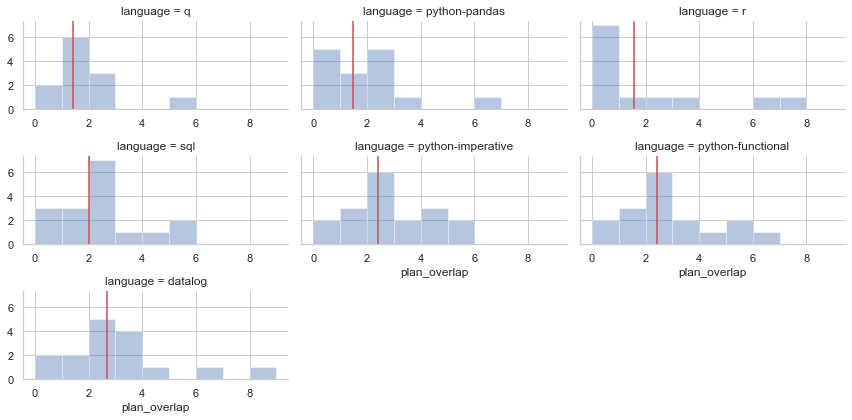

In [34]:
def coord_to_1d(lines, line, column):
    return sum([len(l) for l in lines[:line]]) + column        
    
def plan_overlap(row):
    lines = row.source.split('\n')
    plan_df = pd.DataFrame([{'key': k, **v} for k, vs in row.plan.items() for v in vs])
    plan_df['byte_start'] = plan_df.apply(lambda row: coord_to_1d(lines, row.line, row.start), axis=1)
    plan_df['byte_end'] = plan_df.apply(lambda row: coord_to_1d(lines, row.line, row.end), axis=1)

    full_intervals = plan_df.groupby('key').apply(
        lambda rows: interval[rows.byte_start.min(), rows.byte_end.max()])
    all_pairs = combinations(full_intervals.tolist(), r=2)
    return sum([1 if l & r else 0 for (l, r) in all_pairs])

programs['plan_overlap'] = programs.apply(plan_overlap, axis=1)
order = programs.groupby('language').plan_overlap.mean().sort_values().index.values
g = sns.FacetGrid(data=programs, col='language', col_wrap=3, aspect=2, height=2, col_order=order)
g.map(sns.distplot, 'plan_overlap', kde=False, bins=np.arange(0, programs.plan_overlap.max()+1))
for i, ax in enumerate(g.axes.flatten()):
    ax.axvline(programs[programs.language == order[i]].plan_overlap.mean(), color='r')
    ax.tick_params(labelbottom=True)    
plt.tight_layout()